<a href="https://colab.research.google.com/github/armandordorica/Portfolio_Optimization/blob/master/markowitz_portfolio_optimization_master_YFINANCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/My\ Drive/u\ of\ t/APS\ 1051\ Portfolio\ Optimization/Jupyter\ Notebooks/markowitz-portfolio-optimization-master.YFINANCE/

/content/drive/My Drive/u of t/APS 1051 Portfolio Optimization/Jupyter Notebooks/markowitz-portfolio-optimization-master.YFINANCE


In [3]:
ls

 figures/               markowitz_mod.pyc         README.md
 LICENSE                posdef.py                 Report.pdf
 main_mod_RUN_THIS.py   __pycache__/              StockPrices.csv
 markowitz_mod.py       README_INSTRUCTIONS.txt  'toy problem'/


In [4]:
!pip install yfinance

In [5]:
!pip install cvxpy

In [212]:
#this program runs in Python 3.7
#markowitz portfolio, optimized by minimizing variance while stipulating a given return
#written by Chaitanya Joshi, modified by Loren Trigo

import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from datetime import datetime
import matplotlib.pyplot as plt
from markowitz_mod import MarkowitzOpt

"""
StockList = ['AAPL','IBM','MSFT','GOOG','QCOM']		# Stock ticker names
# Read stock prices data
price = pd.read_csv('StockPrices.csv')
price.index = [datetime.strptime(x,'%Y-%m-%d') for x in price['Date']]
#better: price.index=pd.to_datetime(price["Date"])
price = price.drop('Date',1)
"""
#need to install:
#<py35>conda install -c anaconda pandas-datareader
#<py35>pip install yfinance
#Get the data from yahoo
pd.core.common.is_list_like = pd.api.types.is_list_like #datareader problem probably fixed in next version of datareader
from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yf

yf.pdr_override() # <== that's all it takes :-)

start, end = dt.datetime(2009, 1, 30), dt.datetime(2020, 1, 30)
# StockList= ["FDN","IBB","IEZ","IGV","IHE","IHF","IHI","ITA","ITB","IYJ","IYT","IYW","IYZ","KBE","KCE","KIE","PBJ","PBS","SMH","VNQ","TLT"]

StockList= ["XLB","XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY"]

# StockList = ["XLB","XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY", "XTR"]


price = pd.DataFrame()
for ticker in StockList:
    price[ticker]  = pdr.get_data_yahoo(ticker, start=start, end=end).loc[:,'Adj Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


**`interest_rate` determines the risk-free interest rate and `min_return` is the minimum desired return.**

This program works well for values between 0.02 and 0.08 for minimum required return. Outside that interval, the results may be strange.
In any case, the return of the portfolio will be higher, sometimes quite a bit higher than the required return.
You should try various thresholds to see the results.

* `lookback` is the sampling period of the returns. 

* XLB: Materials Select Sector SPDR Fund 
* XLE: Energy Select Sector SPDR Fund
* XLF: Financial Select Sector SPDR
* XLI: Industrial Select Sector SPDR Fund
* XLK: Technology Sector
* XLP: Consumer Staples Select Sector SPDR Fund
* XLU: Utilities Select Sector SPDR Fund
* XLV: Health Care Select Sector SPDR Fund
* XLY: Consumer Discretionary Select Sector SPDR Fund

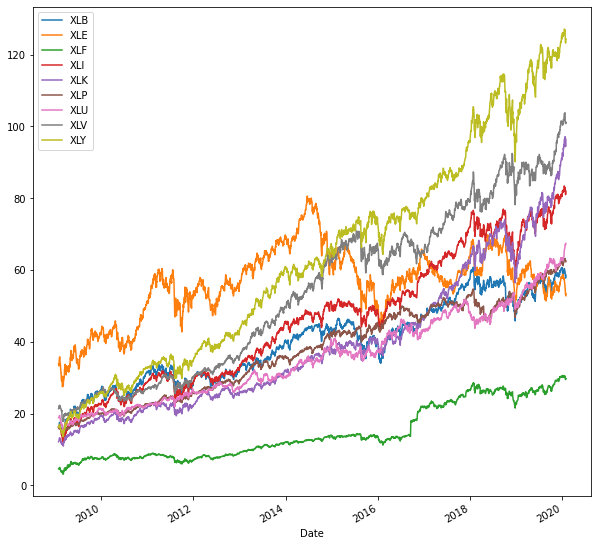

In [213]:
from matplotlib.pyplot import figure
price.plot(figsize=(10,10))

In [214]:
price

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2009-01-30,16.319809,33.823433,4.684322,16.156635,12.169240,16.173187,18.907013,21.366619,16.268377
2009-02-02,16.087332,33.282772,4.684322,15.788186,12.359901,16.034464,19.011400,21.505096,16.116497
2009-02-03,16.397305,33.859470,4.598137,16.078238,12.608595,16.384935,19.096220,22.059015,16.572145
2009-02-04,16.598780,34.176662,4.547442,15.992006,12.600306,15.939534,19.239746,21.961267,16.209305
2009-02-05,17.040491,35.012878,4.618417,16.180151,12.799254,16.165890,19.376759,22.148624,16.513077
...,...,...,...,...,...,...,...,...,...
2020-01-23,59.444023,55.316952,30.327732,82.925148,97.113853,63.173100,66.945274,103.259285,126.817863
2020-01-24,59.019211,54.679569,29.943462,82.539864,96.657501,62.738991,67.122017,101.534996,125.050568
2020-01-27,57.744774,53.163376,29.480368,80.978966,94.355896,62.541668,66.955093,100.762039,123.183998


In [215]:

interest_rate = 0.02/12	# Fixed interest rate
min_return = 0.04		# Minimum desired return
# Specify number of days to shift
shift = 20 #shift the holding period as well as the returns period
lookback = 60

In [216]:
# Compute returns over the time period specified by shift
shift_returns = price/price.shift(shift) - 1

# Specify filter "length"
filter_len = lookback
# Compute mean and variance
shift_returns_mean = shift_returns.ewm(span=filter_len).mean()
shift_returns_var = shift_returns.ewm(span=filter_len).var()
# Compute covariances
NumStocks = len(StockList)
covariance = pd.DataFrame()


In [217]:
NumStocks

9

In [218]:
for FirstStock in np.arange(NumStocks-1):
    for SecondStock in np.arange(FirstStock+1,NumStocks):
        ColumnTitle = StockList[FirstStock] + '-' + StockList[SecondStock]
        covariance[ColumnTitle] = shift_returns[StockList[FirstStock]].ewm(span=filter_len).cov(shift_returns[StockList[SecondStock]].ewm(span=filter_len))

In [219]:
# Variable Initialization
start_date = '2009-06-01'
index = shift_returns.index
start_index = index.get_loc(start_date)
end_date = index[-1]
end_index = index.get_loc(end_date)
date_index_iter = start_index

StockList.append('InterestRate')
distribution = DataFrame(index=StockList)
returns = Series(index=index)
# Start Value
total_value = 1.0
returns[index[date_index_iter]] = total_value

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


In [220]:
covariance

,XLB-XLE,XLB-XLF,XLB-XLI,XLB-XLK,XLB-XLP,XLB-XLU,XLB-XLV,XLB-XLY,XLE-XLF,XLE-XLI,XLE-XLK,XLE-XLP,XLE-XLU,XLE-XLV,XLE-XLY,XLF-XLI,XLF-XLK,XLF-XLP,XLF-XLU,XLF-XLV,XLF-XLY,XLI-XLK,XLI-XLP,XLI-XLU,XLI-XLV,XLI-XLY,XLK-XLP,XLK-XLU,XLK-XLV,XLK-XLY,XLP-XLU,XLP-XLV,XLP-XLY,XLU-XLV,XLU-XLY,XLV-XLY
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-23,0.000613,0.000505,0.000400,0.000215,0.000024,-0.000225,0.000257,0.000117,0.000707,0.000588,0.000515,-0.000001,-0.000108,0.000295,0.000565,0.000468,0.000234,-0.000004,-0.000292,0.000309,0.000162,0.000544,-0.000070,-0.000147,0.000185,0.000236,0.000014,0.000115,0.000189,0.000399,0.000116,0.000065,0.000069,-0.000176,0.000220,0.000062
2020-01-24,0.000678,0.000527,0.000387,0.000189,0.000029,-0.000270,0.000288,0.000125,0.000769,0.000567,0.000456,0.000012,-0.000219,0.000371,0.000572,0.000453,0.000207,0.000002,-0.000335,0.000337,0.000168,0.000526,-0.000068,-0.000141,0.000179,0.000228,0.000011,0.000137,0.000163,0.000380,0.000104,0.000068,0.000068,-0.000223,0.000197,0.000071
2020-01-27,0.000845,0.000612,0.000414,0.000215,0.000045,-0.000338,0.000356,0.000191,0.000917,0.000617,0.000495,0.000041,-0.000343,0.000491,0.000673,0.000475,0.000230,0.000018,-0.000394,0.000397,0.000227,0.000520,-0.000059,-0.000164,0.000201,0.000246,0.000016,0.000111,0.000180,0.000388,0.000089,0.000078,0.000077,-0.000269,0.000142,0.000118


In [221]:


while date_index_iter + shift < end_index:
  print("date_index_iter:{}, shift:{}, end_index:{}".format(date_index_iter, shift, end_index))

  date = index[date_index_iter] 
  print("date:{}".format(date))

  portfolio_alloc = MarkowitzOpt(shift_returns_mean.loc[date], shift_returns_var.loc[date], covariance.loc[date], interest_rate, min_return)
  distribution[date.strftime('%Y-%m-%d')] = portfolio_alloc

  print("# Calculating portfolio return")
  date2 = index[date_index_iter+shift]
  temp1 = price.loc[date2]/price.loc[date]
  temp1.loc[StockList[-1]] = interest_rate+1
  temp2 = Series(np.array(portfolio_alloc.ravel()).reshape(len(portfolio_alloc)),index=StockList)
  total_value = np.sum(total_value*temp2*temp1)
  # Increment Date
  date_index_iter += shift
  returns[index[date_index_iter]] = total_value

date_index_iter:83, shift:20, end_index:2767
date:2009-06-01 00:00:00
# Calculating portfolio return
date_index_iter:103, shift:20, end_index:2767
date:2009-06-29 00:00:00
# Calculating portfolio return
date_index_iter:123, shift:20, end_index:2767
date:2009-07-28 00:00:00
# Calculating portfolio return
date_index_iter:143, shift:20, end_index:2767
date:2009-08-25 00:00:00
# Calculating portfolio return
date_index_iter:163, shift:20, end_index:2767
date:2009-09-23 00:00:00
# Calculating portfolio return
date_index_iter:183, shift:20, end_index:2767
date:2009-10-21 00:00:00
# Calculating portfolio return
date_index_iter:203, shift:20, end_index:2767
date:2009-11-18 00:00:00
# Calculating portfolio return
date_index_iter:223, shift:20, end_index:2767
date:2009-12-17 00:00:00
# Calculating portfolio return
date_index_iter:243, shift:20, end_index:2767
date:2010-01-19 00:00:00
# Calculating portfolio return
date_index_iter:263, shift:20, end_index:2767
date:2010-02-17 00:00:00
# Calculatin

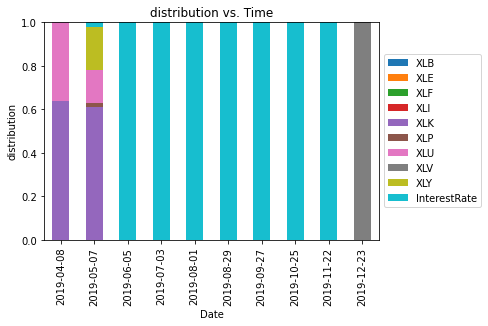

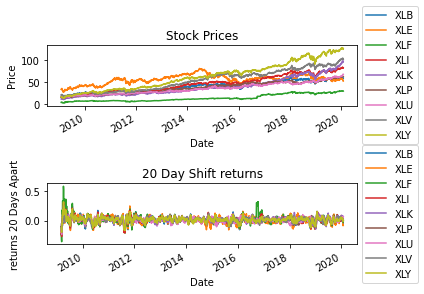

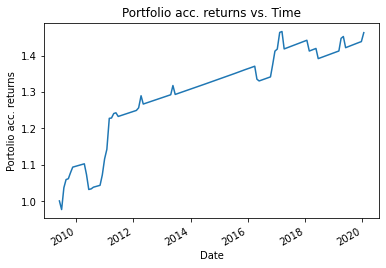

TotaAnnReturn in percent = 4.286284
CAGR in percent = 3.585309
Sharpe Ratio = 0.930000
Sharpe2 Ratio = 0.760000


In [222]:






# Remove dates that there are no trades from returns
returns = returns[np.isfinite(returns)]


# Plot portfolio allocation of last 10 periods
ax = distribution.T.iloc[-10:].plot(kind='bar',stacked=True)
plt.ylim([0,1])
plt.xlabel('Date')
plt.ylabel('distribution')
plt.title('distribution vs. Time')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('allocation.png')

# Plot stock prices and shifted returns
fig, axes = plt.subplots(nrows=2,ncols=1)
price.plot(ax=axes[0])
shift_returns.plot(ax=axes[1])
axes[0].set_title('Stock Prices')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title(str(shift)+ ' Day Shift returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('returns ' + str(shift) + ' Days Apart')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('stocks.png', pad_inches=1)
fig.tight_layout()

# Plot portfolio returns vs. time
plt.figure()
returns.plot()
plt.xlabel('Date')
plt.ylabel('Portolio acc. returns')
plt.title('Portfolio acc. returns vs. Time')
# plt.savefig('returns.png')

plt.show()

df = pd.DataFrame(returns, index=returns.index, columns=['I'])
df["returns"]=(df.I-df.I.shift(1))/df.I.shift(1)
start_date = df.iloc[0].name
end_date = df.iloc[-1].name
days_per_month = 30 #since .days (see below) is calendar days, need to use 30 here
months = (end_date - start_date).days/days_per_month 
periods = 12 #12 months in a year
start_val = df['I'].iat[0]
end_val = df['I'].iat[-1]
years = months/periods

CAGR = ((((end_val/start_val)**(1/years)))-1)
TotaAnnReturn = (end_val-start_val)/start_val/years

try:
    sharpe =  TotaAnnReturn/( (df.returns.std()) * np.sqrt(periods))
except ZeroDivisionError:
    sharpe = 0.0

#this is a more conservataive estimate:
try:
    sharpe2 =  (df.returns.mean()/df.returns.std()) * np.sqrt(periods)
except ZeroDivisionError:
    sharpe2 = 0.0

print ("TotaAnnReturn in percent = %f" %(TotaAnnReturn*100))
print ("CAGR in percent = %f" %(CAGR*100))
print ("Sharpe Ratio = %f" %(round(sharpe,2)))
print ("Sharpe2 Ratio = %f" %(round(sharpe2,2)))


In [223]:
StockList

['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY', 'InterestRate']

In [224]:
portfolio_alloc

array([1.49162916e-05, 1.51979283e-05, 1.40864190e-05, 1.47892521e-05,
       1.40747123e-05, 1.53658244e-05, 1.58620104e-05, 9.99864193e-01,
       1.54645109e-05, 1.60338371e-05])

In [225]:
descriptions = ["XLB: Materials Select Sector SPDR Fund"
,"XLE: Energy Select Sector SPDR Fund"
,"XLF: Financial Select Sector SPDR"
,"XLI: Industrial Select Sector SPDR Fund"
,"XLK: Technology Sector"
,"XLP: Consumer Staples Select Sector SPDR Fund"
,"XLU: Utilities Select Sector SPDR Fund"
,"XLV: Health Care Select Sector SPDR Fund"
,"XLY: Consumer Discretionary Select Sector SPDR Fund"
, "Risk Free Return (short term treasury bill)"]

In [226]:
dict = {'Weight': list(portfolio_alloc), 'Descriptions':descriptions}
weight_dist_df = pd.DataFrame(dict, index= StockList) 

In [227]:
weight_dist_df.sort_values(by="Weight", ascending=False)

,Weight,Descriptions
XLV,0.999864,XLV: Health Care Select Sector SPDR Fund
InterestRate,0.000016,Risk Free Return (short term treasury bill)
XLU,0.000016,XLU: Utilities Select Sector SPDR Fund
XLY,0.000015,XLY: Consumer Discretionary Select Sector SPDR...
XLP,0.000015,XLP: Consumer Staples Select Sector SPDR Fund
XLE,0.000015,XLE: Energy Select Sector SPDR Fund
XLB,0.000015,XLB: Materials Select Sector SPDR Fund
XLI,0.000015,XLI: Industrial Select Sector SPDR Fund
XLF,0.000014,XLF: Financial Select Sector SPDR
XLK,0.000014,XLK: Technology Sector


* Column `['I']` stands for investment. 

In [228]:

df = pd.DataFrame(returns, index=returns.index, columns=['I'])
df["returns"]=(df.I-df.I.shift(1))/df.I.shift(1)
start_date = df.iloc[0].name
end_date = df.iloc[-1].name
days_per_month = 30 #since .days (see below) is calendar days, need to use 30 here
months = (end_date - start_date).days/days_per_month 
periods = 12 #12 months in a year
start_val = df['I'].iat[0]
end_val = df['I'].iat[-1]
years = months/periods

CAGR = ((((end_val/start_val)**(1/years)))-1)
TotaAnnReturn = (end_val-start_val)/start_val/years

try:
    sharpe =  TotaAnnReturn/( (df.returns.std()) * np.sqrt(periods))
except ZeroDivisionError:
    sharpe = 0.0

#this is a more conservataive estimate:
try:
    sharpe2 =  (df.returns.mean()/df.returns.std()) * np.sqrt(periods)
except ZeroDivisionError:
    sharpe2 = 0.0

print ("TotaAnnReturn in percent = %f" %(TotaAnnReturn*100))
print ("CAGR in percent = %f" %(CAGR*100))
print ("Sharpe Ratio = %f" %(round(sharpe,2)))
print ("Sharpe2 Ratio = %f" %(round(sharpe2,2)))
 

TotaAnnReturn in percent = 4.286284
CAGR in percent = 3.585309
Sharpe Ratio = 0.930000
Sharpe2 Ratio = 0.760000


In [229]:
dict = {"TotaAnnReturn in percent":[TotaAnnReturn*100], 'CAGR in percent':[CAGR], 'Sharpe Ratio': [round(sharpe,2)],\
        'Sharpe2 Ratio':[round(sharpe2,2)], 'interest_rate':[interest_rate], 'min_return':[min_return]  }
output = pd.DataFrame(dict) 
output 

,TotaAnnReturn in percent,CAGR in percent,Sharpe Ratio,Sharpe2 Ratio,interest_rate,min_return
0,4.286284,0.035853,0.93,0.76,0.001667,0.04


In [230]:
# # dict = {"TotaAnnReturn in percent":[TotaAnnReturn*100], 'CAGR in percent':[CAGR], 'Sharpe Ratio': [round(sharpe,2)],\
# #         'Sharpe2 Ratio':[round(sharpe2,2)], 'interest_rate':[interest_rate], 'min_return':[min_return]  }
# output_summary = pd.DataFrame(dict) 

In [231]:
output_summary = output_summary.append(output)

**It seems counterintuitive that a low expected minimum return yields the highest annual return and viceversa.** 
* These returns seem too low, especially when compared to market average (they're underperforming). 
* The distribution over time becomes 100% weighted on interest rates and negative weights fo the other ones, which does not make sense if we don't allow for shorting. 

In [232]:
output_summary

,TotaAnnReturn in percent,CAGR in percent,Sharpe Ratio,Sharpe2 Ratio,interest_rate,min_return
0,7.586572,0.056979,1.23,0.90,0.001667,0.02
0,4.079810,0.034381,1.41,1.14,0.001667,0.06
0,3.736395,0.031886,1.17,0.97,0.001667,0.08
0,4.286284,0.035853,0.93,0.76,0.001667,0.04


In [11]:
ls

 figures/               markowitz_mod.pyc         README.md
 LICENSE                posdef.py                 Report.pdf
 main_mod_RUN_THIS.py   __pycache__/              StockPrices.csv
 markowitz_mod.py       README_INSTRUCTIONS.txt  'toy problem'/
